# Demo of the GTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_829274/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_829274/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_829274/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
model = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [9]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
study = model.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-14 12:17:21,750] A new study created in RDB with name: no-name-b7ea4324-de28-48d5-ab76-0bfcf3d286f1
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 2/2000 [00:00<02:29, 13.33it/s]

current_loss: tensor(1.4363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3996, grad_fn=<MeanBackward0>)
current_loss_val:  1.3763290643692017
current_loss: tensor(1.3996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3525, grad_fn=<MeanBackward0>)
current_loss_val:  1.3266832828521729
current_loss: tensor(1.3525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3358, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:33, 13.02it/s]

current_loss_val:  1.3101675510406494
current_loss: tensor(1.3358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3247, grad_fn=<MeanBackward0>)
current_loss_val:  1.297588586807251
current_loss: tensor(1.3247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss_val:  1.2912719249725342
current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3142, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:21, 14.12it/s]

current_loss_val:  1.2882981300354004
current_loss: tensor(1.3142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3133, grad_fn=<MeanBackward0>)
current_loss_val:  1.286732792854309
current_loss: tensor(1.3133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss_val:  1.2798967361450195
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss_val:  1.2794750928878784


  1%|          | 12/2000 [00:00<02:13, 14.88it/s]

current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss_val:  1.2790426015853882
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss_val:  1.2770313024520874
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss_val:  1.275839924812317
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:12, 15.01it/s]

current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss_val:  1.2747466564178467
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2950, grad_fn=<MeanBackward0>)
current_loss_val:  1.2726335525512695
current_loss: tensor(1.2950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, grad_fn=<MeanBackward0>)
current_loss_val:  1.2705857753753662
current_loss: tensor(1.2935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:10, 15.19it/s]

current_loss_val:  1.269879937171936
current_loss: tensor(1.2912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2910, grad_fn=<MeanBackward0>)
current_loss_val:  1.2690751552581787
current_loss: tensor(1.2910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2896, grad_fn=<MeanBackward0>)
current_loss_val:  1.2681828737258911
current_loss: tensor(1.2896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, grad_fn=<MeanBackward0>)
current_loss_val:  1.2680803537368774


  1%|          | 22/2000 [00:01<02:09, 15.33it/s]

current_loss: tensor(1.2893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, grad_fn=<MeanBackward0>)
current_loss_val:  1.267462134361267
current_loss: tensor(1.2884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, grad_fn=<MeanBackward0>)
current_loss_val:  1.268127679824829
current_loss: tensor(1.2883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, grad_fn=<MeanBackward0>)
current_loss_val:  1.2674829959869385
current_loss: tensor(1.2878, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:09, 15.30it/s]

current_loss: tensor(1.2877, grad_fn=<MeanBackward0>)
current_loss_val:  1.2673629522323608
current_loss: tensor(1.2877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, grad_fn=<MeanBackward0>)
current_loss_val:  1.2673102617263794
current_loss: tensor(1.2876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss_val:  1.2670832872390747
current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:01<02:09, 15.26it/s]

current_loss_val:  1.266464352607727
current_loss: tensor(1.2865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, grad_fn=<MeanBackward0>)
current_loss_val:  1.2644914388656616
current_loss: tensor(1.2851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, grad_fn=<MeanBackward0>)
current_loss_val:  1.2615077495574951
current_loss: tensor(1.2828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, grad_fn=<MeanBackward0>)
current_loss_val:  1.2610136270523071


  2%|▏         | 32/2000 [00:02<02:09, 15.25it/s]

current_loss: tensor(1.2818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, grad_fn=<MeanBackward0>)
current_loss_val:  1.2610312700271606
current_loss: tensor(1.2816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss_val:  1.260954737663269
current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, grad_fn=<MeanBackward0>)
current_loss_val:  1.2610012292861938
current_loss: tensor(1.2800, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:08, 15.24it/s]

current_loss: tensor(1.2798, grad_fn=<MeanBackward0>)
current_loss_val:  1.2609033584594727
current_loss: tensor(1.2798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss_val:  1.260828971862793
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss_val:  1.260793685913086
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:08, 15.28it/s]

current_loss_val:  1.2606011629104614
current_loss: tensor(1.2795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss_val:  1.2605808973312378
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, grad_fn=<MeanBackward0>)
current_loss_val:  1.2605807781219482
current_loss: tensor(1.2793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, grad_fn=<MeanBackward0>)
current_loss_val:  1.2604445219039917


  2%|▏         | 42/2000 [00:02<02:09, 15.12it/s]

current_loss: tensor(1.2791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, grad_fn=<MeanBackward0>)
current_loss_val:  1.260170817375183
current_loss: tensor(1.2790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, grad_fn=<MeanBackward0>)
current_loss_val:  1.2598768472671509
current_loss: tensor(1.2785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss_val:  1.2598340511322021


  2%|▏         | 44/2000 [00:02<02:15, 14.40it/s]

current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss_val:  1.2597967386245728
current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss_val:  1.2597287893295288
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss_val:  1.259702205657959


  2%|▏         | 46/2000 [00:03<02:12, 14.75it/s]

current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss_val:  1.2594581842422485
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss_val:  1.2588815689086914
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:23, 13.59it/s]

current_loss_val:  1.2584229707717896
current_loss: tensor(1.2769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss_val:  1.2577240467071533
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss_val:  1.2570035457611084
current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:41, 12.04it/s]

current_loss_val:  1.256502628326416
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558789253234863
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss_val:  1.25584077835083
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<03:14, 10.01it/s]

current_loss_val:  1.2558554410934448
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss_val:  1.256070613861084
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<03:24,  9.49it/s]

current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss_val:  1.2560603618621826
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:32, 12.71it/s]

current_loss_val:  1.256041169166565
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559542655944824
Early Stop at iteration 57 with minimal loss tensor(1.2558) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:17:32,624] Trial 0 finished with value: -2.511681079864502 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.647526534542412, 'penalty_decorrelation_ridge_second_difference': 3.625989943842151}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 1/2000 [00:00<06:08,  5.43it/s]

current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)
current_loss_val:  1.25592839717865
current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<07:49,  4.26it/s]

current_loss: tensor(1.2792, grad_fn=<MeanBackward0>)
current_loss_val:  1.2560588121414185
current_loss: tensor(1.2792, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:53,  3.75it/s]

current_loss: tensor(1.2798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561529874801636


  0%|          | 4/2000 [00:01<08:36,  3.86it/s]

current_loss: tensor(1.2791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561020851135254


  0%|          | 5/2000 [00:01<08:03,  4.13it/s]

current_loss: tensor(1.2789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss_val:  1.256129264831543
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:44,  3.42it/s]

current_loss: tensor(1.2785, grad_fn=<MeanBackward0>)
current_loss_val:  1.2563105821609497
Early Stop at iteration 5 with minimal loss tensor(1.2559) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:17:35,078] Trial 1 finished with value: -2.511857032775879 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.694760166720942, 'penalty_decorrelation_ridge_second_difference': 7.092434386717487}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 1/2000 [00:00<06:55,  4.82it/s]

current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559113502502441


  0%|          | 2/2000 [00:00<05:57,  5.60it/s]

current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559387683868408
current_loss: tensor(1.2769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:42,  5.83it/s]

current_loss_val:  1.2559744119644165
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, grad_fn=<MeanBackward0>)
current_loss_val:  1.2560011148452759


  0%|          | 5/2000 [00:00<06:03,  5.48it/s]

current_loss: tensor(1.2761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)
current_loss_val:  1.2560207843780518


  0%|          | 5/2000 [00:01<07:07,  4.66it/s]


current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss_val:  1.2560231685638428
Early Stop at iteration 5 with minimal loss tensor(1.2559) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:17:37,169] Trial 2 finished with value: -2.511822462081909 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.18906385894863, 'penalty_decorrelation_ridge_second_difference': 22.907735119151432}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 1/2000 [00:00<05:30,  6.05it/s]

current_loss: tensor(1.2893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562475204467773


  0%|          | 2/2000 [00:00<06:38,  5.01it/s]

current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562223672866821


  0%|          | 3/2000 [00:00<08:10,  4.07it/s]

current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562127113342285


  0%|          | 4/2000 [00:00<07:13,  4.60it/s]

current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562458515167236
current_loss: tensor(1.2862, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:13,  4.60it/s]

current_loss: tensor(1.2853, grad_fn=<MeanBackward0>)
current_loss_val:  1.256598949432373
current_loss: tensor(1.2853, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:09,  4.65it/s]

current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss_val:  1.257367730140686
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<07:28,  4.44it/s]

current_loss_val:  1.257461667060852
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)
current_loss_val:  1.2574381828308105
Early Stop at iteration 7 with minimal loss tensor(1.2562) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:17:39,727] Trial 3 finished with value: -2.5124258995056152 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.431218146731485, 'penalty_decorrelation_ridge_second_difference': 20.75423872275492}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<12:23,  2.69it/s]

current_loss_val:  1.256123661994934
current_loss: tensor(1.2864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:08,  4.09it/s]

current_loss_val:  1.2563698291778564
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss_val:  1.2565993070602417


  0%|          | 4/2000 [00:01<07:29,  4.44it/s]

current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)
current_loss_val:  1.2570387125015259
current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:16,  4.57it/s]

current_loss: tensor(1.2840, grad_fn=<MeanBackward0>)
current_loss_val:  1.2571109533309937
current_loss: tensor(1.2840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:19,  3.57it/s]


current_loss_val:  1.2571560144424438
Early Stop at iteration 5 with minimal loss tensor(1.2561) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:17:42,187] Trial 4 finished with value: -2.5122475624084473 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.474143915626279, 'penalty_decorrelation_ridge_second_difference': 12.282629871432851}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 1/2000 [00:00<07:02,  4.73it/s]

current_loss: tensor(1.2885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, grad_fn=<MeanBackward0>)
current_loss_val:  1.256028413772583


  0%|          | 2/2000 [00:00<06:35,  5.05it/s]

current_loss: tensor(1.2873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561627626419067
current_loss: tensor(1.2864, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<05:53,  5.66it/s]

current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss_val:  1.2564191818237305
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:37,  5.90it/s]

current_loss_val:  1.256779432296753
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, grad_fn=<MeanBackward0>)
current_loss_val:  1.2570651769638062


  0%|          | 5/2000 [00:01<06:59,  4.76it/s]


current_loss: tensor(1.2844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, grad_fn=<MeanBackward0>)
current_loss_val:  1.257106065750122
Early Stop at iteration 5 with minimal loss tensor(1.2560) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:17:44,258] Trial 5 finished with value: -2.512056827545166 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.370747333898047, 'penalty_decorrelation_ridge_second_difference': 23.51193727044799}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<11:02,  3.02it/s]

current_loss_val:  1.2559313774108887
current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:32,  4.41it/s]

current_loss_val:  1.2559806108474731
current_loss: tensor(1.2793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss_val:  1.2560734748840332


  0%|          | 4/2000 [00:00<06:30,  5.11it/s]

current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561774253845215
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:00,  4.15it/s]

current_loss_val:  1.256276249885559
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)
current_loss_val:  1.2563023567199707
Early Stop at iteration 5 with minimal loss tensor(1.2559) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:17:46,371] Trial 6 finished with value: -2.5118627548217773 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.313920455321658, 'penalty_decorrelation_ridge_second_difference': 29.243935076103835}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3029, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<12:39,  2.63it/s]

current_loss_val:  1.256666660308838
current_loss: tensor(1.3029, grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 2/2000 [00:00<10:17,  3.23it/s]

tensor(1.3001, grad_fn=<MeanBackward0>)
current_loss_val:  1.2569835186004639
current_loss: tensor(1.3001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2988, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:00,  4.74it/s]

current_loss_val:  1.2572486400604248
current_loss: tensor(1.2988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss_val:  1.2580084800720215


  0%|          | 5/2000 [00:01<06:40,  4.98it/s]

current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss_val:  1.2590757608413696
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:46,  3.79it/s]


current_loss: tensor(1.2955, grad_fn=<MeanBackward0>)
current_loss_val:  1.2595442533493042
Early Stop at iteration 5 with minimal loss tensor(1.2567) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:17:48,621] Trial 7 finished with value: -2.513333320617676 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.747194084417504, 'penalty_decorrelation_ridge_second_difference': 18.14496148548734}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 1/2000 [00:00<05:37,  5.92it/s]

current_loss: tensor(1.2902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561200857162476
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:22,  6.20it/s]

current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss_val:  1.2569838762283325
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:22,  6.19it/s]

current_loss_val:  1.2574630975723267
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, grad_fn=<MeanBackward0>)
current_loss_val:  1.257305383682251
current_loss: tensor(1.2862, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:11,  6.40it/s]

current_loss: tensor(1.2861, grad_fn=<MeanBackward0>)
current_loss_val:  1.257262945175171
current_loss: tensor(1.2861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<06:19,  5.25it/s]


current_loss_val:  1.2572332620620728
Early Stop at iteration 5 with minimal loss tensor(1.2561) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:17:50,554] Trial 8 finished with value: -2.512240409851074 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.45936391845907, 'penalty_decorrelation_ridge_second_difference': 5.790248793001566}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 1/2000 [00:00<04:25,  7.54it/s]

current_loss: tensor(1.2893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562463283538818
current_loss: tensor(1.2886, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:49,  5.71it/s]

current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562252283096313
current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:36,  5.94it/s]

current_loss_val:  1.2562170028686523
current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562522888183594


  0%|          | 5/2000 [00:00<05:44,  5.79it/s]

current_loss: tensor(1.2862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, grad_fn=<MeanBackward0>)
current_loss_val:  1.2566152811050415
current_loss: tensor(1.2853, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<05:40,  5.86it/s]

current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss_val:  1.2573611736297607
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<06:15,  5.31it/s]

current_loss_val:  1.2574560642242432
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)
current_loss_val:  1.257436990737915
Early Stop at iteration 7 with minimal loss tensor(1.2562) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:17:52,730] Trial 9 finished with value: -2.5124340057373047 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.461493316245832, 'penalty_decorrelation_ridge_second_difference': 20.592390978435564}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3040, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<17:37,  1.89it/s]

current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss_val:  1.25620698928833


  0%|          | 2/2000 [00:00<10:16,  3.24it/s]

current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss_val:  1.2565269470214844
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2973, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<06:45,  4.92it/s]

current_loss_val:  1.2571226358413696
current_loss: tensor(1.2973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss_val:  1.2581610679626465
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<06:28,  5.13it/s]

current_loss: tensor(1.2950, grad_fn=<MeanBackward0>)
current_loss_val:  1.2587922811508179
current_loss: tensor(1.2950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:50,  3.76it/s]


current_loss_val:  1.2588441371917725
Early Stop at iteration 5 with minimal loss tensor(1.2562) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:17:54,777] Trial 10 finished with value: -2.51241397857666 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.874257611432522, 'penalty_decorrelation_ridge_second_difference': 26.851147170752174}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 2/2000 [00:00<02:12, 15.09it/s]

current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, grad_fn=<MeanBackward0>)
current_loss_val:  1.2560895681381226
current_loss: tensor(1.2888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss_val:  1.2570269107818604
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, grad_fn=<MeanBackward0>)
current_loss_val:  1.257519245147705


  0%|          | 5/2000 [00:00<02:46, 11.97it/s]

current_loss: tensor(1.2863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, grad_fn=<MeanBackward0>)
current_loss_val:  1.2576229572296143
current_loss: tensor(1.2861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, grad_fn=<MeanBackward0>)
current_loss_val:  1.2577600479125977
current_loss: tensor(1.2857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2856, grad_fn=<MeanBackward0>)
current_loss_val:  1.2578593492507935
Early Stop at iteration 5 with minimal loss tensor(1.2561) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:17:55,893] Trial 11 finished with value: -2.512179136276245 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.95218811581922, 'penalty_decorrelation_ridge_second_difference': 2.4534949456693287}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 2/2000 [00:00<02:29, 13.36it/s]

current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2990, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561683654785156
current_loss: tensor(1.2990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss_val:  1.2564473152160645
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss_val:  1.2569814920425415


  0%|          | 5/2000 [00:00<02:43, 12.17it/s]

current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2939, grad_fn=<MeanBackward0>)
current_loss_val:  1.2578860521316528
current_loss: tensor(1.2939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2933, grad_fn=<MeanBackward0>)
current_loss_val:  1.2584723234176636
current_loss: tensor(1.2933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2928, grad_fn=<MeanBackward0>)
current_loss_val:  1.2585245370864868
Early Stop at iteration 5 with minimal loss tensor(1.2562) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:17:56,986] Trial 12 finished with value: -2.5123367309570312 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.779541260412227, 'penalty_decorrelation_ridge_second_difference': 26.94557862558733}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 2/2000 [00:00<02:07, 15.71it/s]

current_loss: tensor(1.2903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561744451522827
current_loss: tensor(1.2888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, grad_fn=<MeanBackward0>)
current_loss_val:  1.2565889358520508
current_loss: tensor(1.2876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568954229354858
current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:34, 12.88it/s]

current_loss: tensor(1.2863, grad_fn=<MeanBackward0>)
current_loss_val:  1.2574834823608398
current_loss: tensor(1.2863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)
current_loss_val:  1.2574106454849243
current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2859, grad_fn=<MeanBackward0>)
current_loss_val:  1.2574771642684937
Early Stop at iteration 5 with minimal loss tensor(1.2562) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:17:57,988] Trial 13 finished with value: -2.5123486518859863 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.748290652896344, 'penalty_decorrelation_ridge_second_difference': 11.134594776161734}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 2/2000 [00:00<02:09, 15.39it/s]

current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss_val:  1.256534218788147
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, grad_fn=<MeanBackward0>)
current_loss_val:  1.2580057382583618
current_loss: tensor(1.2984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, grad_fn=<MeanBackward0>)
current_loss_val:  1.2587164640426636
current_loss: tensor(1.2969, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:36, 12.76it/s]

current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss_val:  1.2591313123703003
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2955, grad_fn=<MeanBackward0>)
current_loss_val:  1.2594894170761108
current_loss: tensor(1.2955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2949, grad_fn=<MeanBackward0>)
current_loss_val:  1.260212779045105
Early Stop at iteration 5 with minimal loss tensor(1.2565) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:17:59,076] Trial 14 finished with value: -2.513068437576294 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.771592626826493, 'penalty_decorrelation_ridge_second_difference': 8.655949137848106}. Best is trial 0 with value: -2.511681079864502.
  0%|          | 2/2000 [00:00<02:06, 15.77it/s]

current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556509971618652
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557564973831177
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss_val:  1.255771279335022


  0%|          | 4/2000 [00:00<02:35, 12.83it/s]

current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss_val:  1.2560762166976929
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558268308639526
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:05, 10.73it/s]


current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556860446929932
Early Stop at iteration 5 with minimal loss tensor(1.2557) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:00,169] Trial 15 finished with value: -2.5113022327423096 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.09307163943455965, 'penalty_decorrelation_ridge_second_difference': 1.3340238577406254}. Best is trial 15 with value: -2.5113022327423096.
  0%|          | 2/2000 [00:00<02:08, 15.56it/s]

current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.25565505027771
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556548118591309
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556663751602173


  0%|          | 4/2000 [00:00<02:35, 12.86it/s]

current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559161186218262
current_loss: tensor(1.2640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556663751602173
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:35, 12.82it/s]

current_loss_val:  1.2555676698684692
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss_val:  1.255316972732544
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550957202911377
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:34, 12.92it/s]

current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss_val:  1.255547285079956
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555415630340576
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554353475570679
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:43, 12.12it/s]

current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553902864456177
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552824020385742
Early Stop at iteration 12 with minimal loss tensor(1.2551) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:18:01,790] Trial 16 finished with value: -2.5101914405822754 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.320229433541634, 'penalty_decorrelation_ridge_second_difference': 1.3488003031303246}. Best is trial 16 with value: -2.5101914405822754.
  0%|          | 2/2000 [00:00<02:10, 15.34it/s]

current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558091878890991
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557460069656372
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556564807891846
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:12, 15.07it/s]

current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555303573608398
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553523778915405
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.255267858505249
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:12, 14.99it/s]

current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552378177642822
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552103996276855
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551645040512085
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:12, 15.03it/s]

current_loss_val:  1.255161166191101
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551376819610596
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.25510835647583
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550973892211914


  1%|          | 16/2000 [00:01<02:10, 15.21it/s]

current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.255062460899353
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550591230392456
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550557851791382
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:10, 15.23it/s]

current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550078630447388
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549715042114258
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550009489059448
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:10, 15.14it/s]

current_loss_val:  1.2549105882644653
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548906803131104
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548606395721436
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:09, 15.26it/s]

current_loss_val:  1.2548494338989258
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548009157180786
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss_val:  1.254785418510437
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.2546370029449463


  1%|▏         | 28/2000 [00:01<02:09, 15.29it/s]

current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544498443603516
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.254439115524292
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.254416823387146
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:11, 15.02it/s]

current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543904781341553
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543551921844482
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543078660964966
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:10, 15.10it/s]

current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542548179626465
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2539480924606323
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2537308931350708
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:16, 14.41it/s]

current_loss_val:  1.2536683082580566
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.2534270286560059
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2532094717025757
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:02<02:12, 14.78it/s]

current_loss_val:  1.2531894445419312
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2531275749206543
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529340982437134
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.252925992012024


  2%|▏         | 44/2000 [00:02<02:11, 14.92it/s]

current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529233694076538
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529138326644897
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529085874557495
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:09, 15.04it/s]

current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528713941574097
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<03:11, 10.19it/s]

current_loss_val:  1.2528358697891235
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.252811312675476
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2527340650558472
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:46, 11.72it/s]

current_loss_val:  1.2527145147323608
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526510953903198
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526131868362427
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:03<02:25, 13.32it/s]

current_loss_val:  1.252575397491455
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524820566177368
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.252414584159851
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524232864379883


  3%|▎         | 58/2000 [00:04<02:20, 13.82it/s]

current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524386644363403
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524559497833252
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524501085281372


  3%|▎         | 59/2000 [00:04<02:19, 13.93it/s]


current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524510622024536
Early Stop at iteration 59 with minimal loss tensor(1.2524) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:06,684] Trial 17 finished with value: -2.504829168319702 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.6751114044214828, 'penalty_decorrelation_ridge_second_difference': 15.042813285522236}. Best is trial 17 with value: -2.504829168319702.
  0%|          | 2/2000 [00:00<02:11, 15.18it/s]

current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558671236038208
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558233737945557
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557592391967773


  0%|          | 6/2000 [00:00<02:17, 14.50it/s]

current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556579113006592
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557203769683838
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555630207061768
current_loss: 

  0%|          | 8/2000 [00:00<02:15, 14.74it/s]

tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555463314056396
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss_val:  1.255548357963562
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss_val:  1.255454659461975
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:14, 14.79it/s]

current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554439306259155
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553926706314087
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss_val:  1.255251169204712
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 14/2000 [00:00<02:12, 14.96it/s]

tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552741765975952
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552316188812256
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss_val:  1.255218744277954
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:19, 14.24it/s]

current_loss_val:  1.2552156448364258
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss_val:  1.255228877067566
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss_val:  1.255210280418396
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:14, 14.73it/s]

current_loss_val:  1.2551909685134888
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551919221878052
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss_val:  1.25514554977417
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551329135894775


  1%|          | 24/2000 [00:01<02:19, 14.17it/s]

current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550519704818726
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550208568572998
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:18, 14.27it/s]

current_loss_val:  1.2549519538879395
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548798322677612
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548277378082275
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:18, 14.19it/s]

current_loss_val:  1.2547433376312256
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542989253997803
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss_val:  1.2539039850234985
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss_val:  1.2535258531570435


  2%|▏         | 34/2000 [00:02<02:14, 14.65it/s]

current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss_val:  1.2532521486282349
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530583143234253
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss_val:  1.25290846824646
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:12, 14.80it/s]

current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss_val:  1.252533197402954
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524967193603516
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524443864822388
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:11, 14.88it/s]

current_loss_val:  1.2523301839828491
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521611452102661
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss_val:  1.252111792564392
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520625591278076


  2%|▏         | 44/2000 [00:03<02:09, 15.07it/s]

current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.252069354057312
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.252079725265503
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.252128005027771
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:17, 14.25it/s]


current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521675825119019
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521737813949585
Early Stop at iteration 45 with minimal loss tensor(1.2521) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:10,464] Trial 18 finished with value: -2.5041251182556152 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.867742855043293, 'penalty_decorrelation_ridge_second_difference': 13.820186406076322}. Best is trial 18 with value: -2.5041251182556152.
  0%|          | 2/2000 [00:00<02:07, 15.61it/s]

current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.255768060684204
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556477785110474
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554842233657837
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:12, 15.05it/s]

current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.255325198173523
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552746534347534
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.255278468132019
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:11, 15.18it/s]

current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552158832550049
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551323175430298
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.255135416984558
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:12, 14.97it/s]

current_loss_val:  1.2551133632659912
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550864219665527
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551045417785645
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550925016403198


  1%|          | 15/2000 [00:01<02:20, 14.17it/s]

current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551298141479492
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551133632659912
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551077604293823
Early Stop at iteration 15 with minimal loss tensor(1.2551) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:18:12,142] Trial 19 finished with value: -2.5101726055145264 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.8853637283631168, 'penalty_decorrelation_ridge_second_difference': 12.695966131354808}. Best is trial 18 with value: -2.5041251182556152.
  0%|          | 2/2000 [00:00<02:14, 14.88it/s]

current_loss: tensor(1.2795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559819221496582
current_loss: tensor(1.2790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559728622436523
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559529542922974
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:12, 15.00it/s]

current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559434175491333
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561150789260864
current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561206817626953
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.26it/s]

current_loss_val:  1.2561143636703491
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561068534851074
current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, grad_fn=<MeanBackward0>)
current_loss_val:  1.2560718059539795
Early Stop at iteration 8 with minimal loss tensor(1.2559) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:18:13,396] Trial 20 finished with value: -2.5118868350982666 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.481755842659334, 'penalty_decorrelation_ridge_second_difference': 16.001628046812634}. Best is trial 18 with value: -2.5041251182556152.
  0%|          | 2/2000 [00:00<02:09, 15.42it/s]

current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558090686798096
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557564973831177
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557016611099243
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:10, 15.23it/s]

current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556143999099731
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553471326828003
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552324533462524
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:12, 15.06it/s]

current_loss_val:  1.2552049160003662
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551689147949219
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551140785217285
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550994157791138


  1%|          | 12/2000 [00:00<02:13, 14.87it/s]

current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550878524780273
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550715208053589
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550474405288696
current_loss: 

  1%|          | 16/2000 [00:01<02:12, 14.95it/s]

tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550122737884521
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549904584884644
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549468278884888


  1%|          | 18/2000 [00:01<02:12, 14.99it/s]

current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.254846215248108
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss_val:  1.25484037399292
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548317909240723
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:12, 14.98it/s]

current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.25473952293396
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547171115875244
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547156810760498
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:11, 15.05it/s]

current_loss_val:  1.2547019720077515
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2546740770339966
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2546486854553223
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2545835971832275


  1%|▏         | 28/2000 [00:01<02:10, 15.13it/s]

current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss_val:  1.2545326948165894
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544639110565186
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544184923171997
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:12, 14.90it/s]

current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543479204177856
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542812824249268
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542719841003418
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:11, 14.91it/s]

current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542372941970825
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss_val:  1.25409996509552
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss_val:  1.2538515329360962
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:11, 14.89it/s]

current_loss_val:  1.2538388967514038
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.253823161125183
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.2537585496902466
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:02<02:11, 14.95it/s]

current_loss_val:  1.253732681274414
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536729574203491
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536280155181885
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss_val:  1.2535555362701416


  2%|▏         | 44/2000 [00:02<02:10, 15.00it/s]

current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2534233331680298
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2532994747161865
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2532562017440796
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:14, 14.47it/s]

current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2532607316970825
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.253250241279602
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss_val:  1.2532122135162354
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:20, 13.87it/s]

current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss_val:  1.2532036304473877
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss_val:  1.2531875371932983
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss_val:  1.2531628608703613


  3%|▎         | 54/2000 [00:03<02:19, 13.94it/s]

current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss_val:  1.2531427145004272
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss_val:  1.2531323432922363
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss_val:  1.2531065940856934


  3%|▎         | 56/2000 [00:03<02:22, 13.61it/s]

current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530910968780518
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530800104141235
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:15, 14.30it/s]

current_loss_val:  1.2530604600906372
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530150413513184
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530064582824707
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530057430267334


  3%|▎         | 62/2000 [00:04<02:13, 14.49it/s]

current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529984712600708
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528923749923706
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529062032699585
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:04<02:11, 14.71it/s]

current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528955936431885
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528880834579468
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.25288724899292
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:04<02:16, 14.13it/s]

current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528951168060303
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528932094573975
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.252884864807129
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:04<02:20, 13.75it/s]

current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528785467147827
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.252878189086914
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528730630874634
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:16, 14.12it/s]

current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528470754623413
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528293132781982
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss_val:  1.252817153930664
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:05<02:12, 14.51it/s]

current_loss_val:  1.2527884244918823
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss_val:  1.252756118774414
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss_val:  1.252716064453125
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:05<02:09, 14.78it/s]

current_loss_val:  1.252661943435669
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526360750198364
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526376247406006
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526462078094482


  4%|▍         | 84/2000 [00:05<02:20, 13.67it/s]

current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526748180389404
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526845932006836
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:05<02:13, 14.38it/s]


current_loss_val:  1.252690076828003
Early Stop at iteration 84 with minimal loss tensor(1.2526) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:19,888] Trial 21 finished with value: -2.505272388458252 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6992159516161411, 'penalty_decorrelation_ridge_second_difference': 16.98550018175031}. Best is trial 18 with value: -2.5041251182556152.
  0%|          | 2/2000 [00:00<02:37, 12.67it/s]

current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558469772338867
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558187246322632
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:21, 14.13it/s]

current_loss_val:  1.2557214498519897
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556036710739136
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554700374603271
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:16, 14.55it/s]

current_loss_val:  1.2553863525390625
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552788257598877
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551759481430054
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551562786102295


  1%|          | 12/2000 [00:00<02:14, 14.81it/s]

current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551548480987549
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.255140781402588
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551052570343018


  1%|          | 14/2000 [00:00<02:13, 14.90it/s]

current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.255048394203186
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550123929977417
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549995183944702
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:13, 14.81it/s]

current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.254960298538208
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549508810043335
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549489736557007
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:12, 14.95it/s]

current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549433708190918
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549229860305786
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548342943191528
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:13, 14.85it/s]

current_loss_val:  1.2548235654830933
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548127174377441
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547913789749146
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547658681869507


  1%|▏         | 28/2000 [00:01<02:09, 15.18it/s]

current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547603845596313
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547513246536255
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547353506088257
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:21, 13.90it/s]

current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2546484470367432
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.254584789276123
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544851303100586


  2%|▏         | 34/2000 [00:02<02:17, 14.33it/s]

current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542985677719116
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541762590408325
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.254166841506958


  2%|▏         | 36/2000 [00:02<02:15, 14.52it/s]

current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541415691375732
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541050910949707
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:22, 13.76it/s]

current_loss_val:  1.2540862560272217
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540829181671143
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540842294692993
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:02<02:15, 14.40it/s]

current_loss_val:  1.2540830373764038
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540799379348755
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.254075527191162
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540658712387085


  2%|▏         | 46/2000 [00:03<02:12, 14.79it/s]

current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540335655212402
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540373802185059
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540396451950073
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:11, 14.89it/s]

current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540446519851685
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540348768234253
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.254022479057312
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:11, 14.78it/s]

current_loss_val:  1.2539957761764526
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.253935694694519
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.253891110420227
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:15, 14.37it/s]

current_loss_val:  1.2537879943847656
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2535876035690308
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss_val:  1.253428339958191
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:23, 13.56it/s]

current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.252705454826355
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.2525215148925781
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss_val:  1.2523963451385498


  3%|▎         | 60/2000 [00:04<02:19, 13.87it/s]

current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss_val:  1.2522069215774536
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521495819091797
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.252122163772583


  3%|▎         | 64/2000 [00:04<02:15, 14.30it/s]

current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521140575408936
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.252083420753479
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520442008972168


  3%|▎         | 66/2000 [00:04<02:14, 14.43it/s]

current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520418167114258
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.252037525177002
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520276308059692


  3%|▎         | 68/2000 [00:04<02:11, 14.65it/s]

current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.251958966255188
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2519410848617554
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:04<02:14, 14.30it/s]

current_loss_val:  1.251926064491272
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2519049644470215
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2518776655197144
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:13, 14.42it/s]

current_loss_val:  1.2518737316131592
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.251875638961792
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2518898248672485
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2518813610076904


  4%|▍         | 78/2000 [00:05<02:11, 14.60it/s]

current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2518796920776367
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2518715858459473
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.25187087059021


  4%|▍         | 80/2000 [00:05<02:10, 14.70it/s]

current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2518908977508545


  4%|▍         | 82/2000 [00:05<03:09, 10.15it/s]

current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2519129514694214
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss_val:  1.251966118812561
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss_val:  1.251993179321289
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)


  4%|▍         | 83/2000 [00:05<02:18, 13.84it/s]


current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss_val:  1.252015233039856
Early Stop at iteration 83 with minimal loss tensor(1.2519) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:26,522] Trial 22 finished with value: -2.50374174118042 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.8029075908551297, 'penalty_decorrelation_ridge_second_difference': 21.552967331959728}. Best is trial 22 with value: -2.50374174118042.
  0%|          | 2/2000 [00:00<02:30, 13.26it/s]

current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558623552322388
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558478116989136
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557860612869263


  0%|          | 6/2000 [00:00<02:17, 14.52it/s]

current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557032108306885
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss_val:  1.255602240562439
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555396556854248


  0%|          | 8/2000 [00:00<02:15, 14.71it/s]

current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554503679275513
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553406953811646
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss_val:  1.255319356918335
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:15, 14.66it/s]

current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553105354309082
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552567720413208
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551895380020142
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:14, 14.78it/s]

current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551231384277344
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550897598266602
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550561428070068
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:13, 14.81it/s]

current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550088167190552
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550004720687866
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:24, 13.69it/s]

current_loss_val:  1.255000352859497
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549980878829956
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549890279769897
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:27, 13.38it/s]

current_loss_val:  1.2549561262130737
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549313306808472
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548807859420776
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:19, 14.14it/s]

current_loss_val:  1.2548471689224243
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548174858093262
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547539472579956
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.2546342611312866


  2%|▏         | 30/2000 [00:02<02:15, 14.58it/s]

current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.254543662071228
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543929815292358
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540993690490723
current_loss: 

  2%|▏         | 32/2000 [00:02<02:13, 14.69it/s]

tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss_val:  1.2539669275283813
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss_val:  1.2538849115371704
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.2534693479537964
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:18, 14.20it/s]

current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.2533636093139648
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.2532999515533447
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.2531392574310303


  2%|▏         | 38/2000 [00:02<02:22, 13.76it/s]

current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.2531086206436157
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530975341796875
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529860734939575


  2%|▏         | 40/2000 [00:02<02:26, 13.37it/s]

current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529667615890503
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529598474502563
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:18, 14.13it/s]

current_loss_val:  1.2529157400131226
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528618574142456
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528626918792725
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528786659240723


  2%|▏         | 48/2000 [00:03<02:15, 14.38it/s]

current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528201341629028
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528116703033447
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528035640716553


  2%|▎         | 50/2000 [00:03<02:14, 14.54it/s]

current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.252779245376587
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2527207136154175
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526775598526
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:12, 14.63it/s]

current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526522874832153
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526538372039795
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526532411575317
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:03<02:11, 14.74it/s]

current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526484727859497
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.252644419670105
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.252639889717102
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:14, 14.38it/s]

current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526381015777588
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526274919509888
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2525911331176758
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: 

  3%|▎         | 62/2000 [00:04<02:14, 14.38it/s]

tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2525266408920288
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524875402450562
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524631023406982
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:04<02:13, 14.50it/s]

current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524055242538452
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2523908615112305
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2523905038833618
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:04<02:11, 14.65it/s]

current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2523903846740723
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2523725032806396
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2523715496063232
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:12, 14.57it/s]

current_loss_val:  1.252372145652771
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2523797750473022
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524030208587646
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:16, 14.16it/s]


current_loss_val:  1.2524657249450684
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524871826171875
Early Stop at iteration 73 with minimal loss tensor(1.2524) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:32,239] Trial 23 finished with value: -2.5047430992126465 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.950966694189071, 'penalty_decorrelation_ridge_second_difference': 22.359365068539066}. Best is trial 22 with value: -2.50374174118042.
  0%|          | 2/2000 [00:00<02:31, 13.19it/s]

current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558660507202148
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558571100234985
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558082342147827


  0%|          | 6/2000 [00:00<02:17, 14.53it/s]

current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss_val:  1.255739688873291
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556489706039429
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555873394012451


  0%|          | 8/2000 [00:00<02:16, 14.55it/s]

current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.255494236946106
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss_val:  1.25535249710083
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553259134292603
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:15, 14.66it/s]

current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553188800811768
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552739381790161
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552133798599243
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:15, 14.68it/s]

current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551465034484863
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551097869873047
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550736665725708
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:25, 13.64it/s]

current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550077438354492
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549992799758911
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.255003571510315


  1%|          | 20/2000 [00:01<02:21, 13.99it/s]

current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550139427185059
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550220489501953
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss_val:  1.254968523979187


  1%|          | 24/2000 [00:01<02:19, 14.20it/s]

current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549363374710083
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549188137054443
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss_val:  1.254867434501648


  1%|▏         | 26/2000 [00:01<02:17, 14.40it/s]

current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548078298568726
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.254745602607727
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.2546947002410889


  1%|▏         | 28/2000 [00:01<02:15, 14.56it/s]

current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.254518747329712
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544349431991577
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:25, 13.55it/s]

current_loss_val:  1.2543902397155762
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.2539821863174438
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.2538976669311523
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:20, 13.96it/s]

current_loss_val:  1.2538516521453857
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536062002182007
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.253564476966858
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:21, 13.83it/s]

current_loss_val:  1.253544569015503
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.2534681558609009
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2533934116363525
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:16, 14.34it/s]

current_loss_val:  1.2533643245697021
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.253347396850586
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2533037662506104
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:15, 14.44it/s]

current_loss_val:  1.253274917602539
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2532539367675781
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.253076195716858
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.252992868423462


  2%|▏         | 48/2000 [00:03<02:12, 14.69it/s]

current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529884576797485
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529844045639038
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.252977728843689


  2%|▎         | 50/2000 [00:03<02:11, 14.79it/s]

current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528825998306274
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528719902038574
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528620958328247
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:12, 14.72it/s]

current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.25285005569458
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.2527810335159302
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.252756118774414
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:03<02:17, 14.12it/s]

current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2527364492416382
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526962757110596
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526708841323853
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:14, 14.40it/s]

current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2526497840881348
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.252632975578308
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2525782585144043
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:12, 14.61it/s]

current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2525532245635986
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.252563238143921
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.252565860748291
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:04<02:17, 14.07it/s]

current_loss_val:  1.2525845766067505
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2525935173034668
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2525991201400757
Early Stop at iteration 65 with minimal loss tensor(1.2526) and patience 5 and min_delta 1e-07



[I 2025-10-14 12:18:37,419] Trial 24 finished with value: -2.5051064491271973 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3137131244028075, 'penalty_decorrelation_ridge_second_difference': 25.192483772470837}. Best is trial 22 with value: -2.50374174118042.
  0%|          | 2/2000 [00:00<02:29, 13.40it/s]

current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss_val:  1.255864143371582
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558501958847046
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss_val:  1.255790114402771


  0%|          | 6/2000 [00:00<02:22, 13.96it/s]

current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557079792022705
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556129693984985
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555553913116455
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554751634597778


  0%|          | 8/2000 [00:00<03:40,  9.05it/s]

current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553859949111938
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss_val:  1.255362868309021
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:52, 11.55it/s]

current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553517818450928
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552855014801025
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552088499069214
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:43, 12.15it/s]

current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551414966583252
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.255104660987854
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550674676895142


  1%|          | 18/2000 [00:01<02:33, 12.92it/s]

current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550212144851685
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550147771835327
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550137042999268


  1%|          | 20/2000 [00:01<02:27, 13.41it/s]

current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550081014633179
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549951076507568
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549610137939453
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:21, 13.93it/s]

current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549409866333008
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss_val:  1.254926323890686
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548943758010864
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:18, 14.22it/s]

current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548454999923706
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548115253448486
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss_val:  1.2546998262405396
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:16, 14.42it/s]

current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544585466384888
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543984651565552
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543426752090454
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:13, 14.74it/s]

current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540702819824219
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss_val:  1.2537314891815186
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss_val:  1.253719449043274
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:20, 13.95it/s]

current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss_val:  1.2537071704864502
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536942958831787
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536793947219849


  2%|▏         | 38/2000 [00:02<02:17, 14.26it/s]

current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536733150482178
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536683082580566
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.253677248954773
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:14, 14.51it/s]

current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.253685474395752
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536853551864624
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.253686785697937
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:29, 13.11it/s]


current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.253698468208313
Early Stop at iteration 42 with minimal loss tensor(1.2537) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:41,119] Trial 25 finished with value: -2.507336378097534 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.4454855240511706, 'penalty_decorrelation_ridge_second_difference': 21.439570455321334}. Best is trial 22 with value: -2.50374174118042.
  0%|          | 2/2000 [00:00<02:30, 13.31it/s]

current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558608055114746
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558484077453613
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557908296585083


  0%|          | 6/2000 [00:00<02:16, 14.61it/s]

current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss_val:  1.255713939666748
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556105852127075
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.255536675453186
current_loss: 

  0%|          | 8/2000 [00:00<02:14, 14.79it/s]

tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss_val:  1.25542414188385
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552387714385986
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552003860473633
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:13, 14.84it/s]

current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss_val:  1.255198359489441
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551860809326172
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551584243774414
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 14/2000 [00:00<02:13, 14.93it/s]

tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551122903823853
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550814151763916
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550572156906128
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:13, 14.88it/s]

current_loss_val:  1.2549943923950195
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549755573272705
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549821138381958
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549985647201538


  1%|          | 22/2000 [00:01<02:12, 14.98it/s]

current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550163269042969
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549800872802734
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549077272415161
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:11, 15.01it/s]

current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.254883885383606
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548396587371826
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547475099563599
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:01<02:12, 14.92it/s]

current_loss_val:  1.2546592950820923
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2545846700668335
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.2545021772384644
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.254325270652771


  2%|▏         | 32/2000 [00:02<02:11, 15.01it/s]

current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542948722839355
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542773485183716
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542110681533813
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:11, 14.98it/s]

current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541166543960571
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541167736053467
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541158199310303
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:07, 15.43it/s]

current_loss_val:  1.254111647605896
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540881633758545
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540838718414307
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:23, 13.70it/s]

current_loss_val:  1.2540788650512695
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540680170059204
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540448904037476
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:02<02:19, 14.04it/s]

current_loss_val:  1.2540394067764282
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss_val:  1.254027009010315
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540045976638794
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:14, 14.47it/s]

current_loss_val:  1.2538697719573975
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss_val:  1.2538437843322754
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss_val:  1.2538260221481323
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:12, 14.71it/s]

current_loss_val:  1.2537672519683838
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.253768801689148
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2537745237350464
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2537901401519775


  3%|▎         | 52/2000 [00:03<02:14, 14.52it/s]


current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2537904977798462
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2537853717803955
Early Stop at iteration 52 with minimal loss tensor(1.2538) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:45,245] Trial 26 finished with value: -2.5075342655181885 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.007210890188293462, 'penalty_decorrelation_ridge_second_difference': 27.106016734550728}. Best is trial 22 with value: -2.50374174118042.
  0%|          | 2/2000 [00:00<02:13, 15.00it/s]

current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559236288070679
current_loss: tensor(1.2769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559083700180054
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, grad_fn=<MeanBackward0>)
current_loss_val:  1.255881905555725


  0%|          | 6/2000 [00:00<02:23, 13.85it/s]

current_loss: tensor(1.2762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558479309082031
current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559521198272705
current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558820247650146


  0%|          | 8/2000 [00:00<02:18, 14.37it/s]

current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558770179748535
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558839321136475
current_loss: tensor(1.2754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558470964431763
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:16, 14.61it/s]

current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558587789535522
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, grad_fn=<MeanBackward0>)
current_loss_val:  1.255794644355774
current_loss: tensor(1.2752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss_val:  1.255653977394104
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:14, 14.74it/s]

current_loss_val:  1.2555747032165527
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555004358291626
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554737329483032
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:17, 14.46it/s]

current_loss_val:  1.2554829120635986
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553915977478027
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553842067718506
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:28, 13.31it/s]

current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554168701171875
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553772926330566
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553852796554565


  1%|          | 24/2000 [00:01<02:24, 13.70it/s]

current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss_val:  1.255518913269043
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554141283035278
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553895711898804


  1%|▏         | 26/2000 [00:01<02:20, 14.06it/s]

current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553528547286987
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss_val:  1.255340814590454
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss_val:  1.255249261856079
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:16, 14.42it/s]

current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551013231277466
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550522089004517
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550106048583984
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:14, 14.63it/s]

current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss_val:  1.2546586990356445
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544994354248047
current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss_val:  1.254401445388794
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 36/2000 [00:02<02:16, 14.44it/s]

tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543832063674927
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543458938598633
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542095184326172
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:14, 14.57it/s]

current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540762424468994
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss_val:  1.2538989782333374
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss_val:  1.2538632154464722
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:02<02:13, 14.66it/s]

current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss_val:  1.2535219192504883
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530862092971802
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529116868972778


  2%|▏         | 44/2000 [00:03<03:11, 10.22it/s]

current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528034448623657
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss_val:  1.252424716949463
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss_val:  1.252378225326538


  2%|▏         | 48/2000 [00:03<02:40, 12.14it/s]

current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss_val:  1.2523598670959473
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss_val:  1.252341866493225
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss_val:  1.2523378133773804


  2%|▎         | 50/2000 [00:03<02:32, 12.82it/s]

current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss_val:  1.2522714138031006
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521543502807617
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520555257797241
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:21, 13.75it/s]

current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521017789840698
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521029710769653
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521189451217651
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:23, 13.53it/s]


current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521566152572632
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss_val:  1.252155065536499
Early Stop at iteration 55 with minimal loss tensor(1.2521) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:49,993] Trial 27 finished with value: -2.504110813140869 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.156734940828424, 'penalty_decorrelation_ridge_second_difference': 13.994805055286522}. Best is trial 22 with value: -2.50374174118042.
  0%|          | 2/2000 [00:00<02:05, 15.88it/s]

current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559858560562134
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559876441955566
current_loss: tensor(1.2789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, grad_fn=<MeanBackward0>)
current_loss_val:  1.255979061126709
current_loss: tensor(1.2786, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:14, 14.81it/s]

current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559916973114014
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561900615692139
current_loss: tensor(1.2780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561675310134888
current_loss: tensor(1.2778, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:30, 13.25it/s]


current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561482191085815
current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561242580413818
Early Stop at iteration 7 with minimal loss tensor(1.2560) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:51,105] Trial 28 finished with value: -2.511958122253418 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.945730548165013, 'penalty_decorrelation_ridge_second_difference': 15.373643250880562}. Best is trial 22 with value: -2.50374174118042.
  0%|          | 2/2000 [00:00<02:08, 15.60it/s]

current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss_val:  1.255823016166687
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557429075241089
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557414770126343
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:12, 15.10it/s]

current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556331157684326
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555805444717407
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555713653564453
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.06it/s]

current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss_val:  1.255526065826416
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555246353149414
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:40, 12.39it/s]

current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss_val:  1.255581259727478
current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555097341537476
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss_val:  1.25540292263031
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:32, 12.99it/s]

current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss_val:  1.255365252494812
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss_val:  1.255293369293213
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552886009216309


  1%|          | 16/2000 [00:01<02:33, 12.92it/s]

current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss_val:  1.255276083946228
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss_val:  1.255287528038025
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:35, 12.75it/s]

current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552050352096558
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)
current_loss_val:  1.255063533782959
current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549971342086792
current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:28, 13.33it/s]

current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549651861190796
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547358274459839
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss_val:  1.2545472383499146
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:22, 13.83it/s]

current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss_val:  1.254289150238037
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542229890823364
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540311813354492
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:19, 14.16it/s]

current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss_val:  1.253872275352478
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss_val:  1.253633975982666
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss_val:  1.2535420656204224
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:17, 14.38it/s]

current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss_val:  1.2535022497177124
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss_val:  1.2533444166183472
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss_val:  1.2531908750534058
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<05:26,  6.03it/s]

current_loss_val:  1.25309157371521
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss_val:  1.2527257204055786
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<04:12,  7.79it/s]

current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524091005325317
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521711587905884
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520142793655396


  2%|▏         | 38/2000 [00:03<03:35,  9.10it/s]

current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss_val:  1.2519532442092896
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss_val:  1.2519080638885498
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss_val:  1.251894474029541
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<06:30,  5.02it/s]

current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss_val:  1.2518677711486816
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<05:18,  6.16it/s]

current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss_val:  1.251998782157898
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2519950866699219
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520209550857544
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:26,  9.45it/s]


current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.252082347869873
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.252096176147461
Early Stop at iteration 44 with minimal loss tensor(1.2519) and patience 5 and min_delta 1e-07


[I 2025-10-14 12:18:56,403] Trial 29 finished with value: -2.503735303878784 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.555847754164093, 'penalty_decorrelation_ridge_second_difference': 6.334101264349057}. Best is trial 29 with value: -2.503735303878784.


hyperparameter_tuning done


In [11]:
# pretrain the marginal transformations
_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

 16%|█▌        | 158/1000 [00:05<00:28, 29.48it/s]


In [12]:
# train the joint model
_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<01:08, 14.62it/s]

current_loss: tensor(1.4347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3991, grad_fn=<MeanBackward0>)
current_loss_val:  1.3791409730911255
current_loss: tensor(1.3991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3412, grad_fn=<MeanBackward0>)
current_loss_val:  1.3168467283248901
current_loss: tensor(1.3412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3289, grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<01:09, 14.26it/s]

current_loss_val:  1.3057094812393188
current_loss: tensor(1.3289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3223, grad_fn=<MeanBackward0>)
current_loss_val:  1.2978050708770752
current_loss: tensor(1.3223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3199, grad_fn=<MeanBackward0>)
current_loss_val:  1.2963600158691406
current_loss: tensor(1.3199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss_val:  1.289746880531311


  1%|          | 8/1000 [00:00<01:15, 13.11it/s]

current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3086, grad_fn=<MeanBackward0>)
current_loss_val:  1.2868192195892334
current_loss: tensor(1.3086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss_val:  1.2809380292892456
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<01:16, 12.99it/s]

current_loss: tensor(1.2988, grad_fn=<MeanBackward0>)
current_loss_val:  1.2767932415008545
current_loss: tensor(1.2988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss_val:  1.2752714157104492
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2960, grad_fn=<MeanBackward0>)
current_loss_val:  1.2748844623565674
current_loss: tensor(1.2960, grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:09, 14.14it/s]

current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss_val:  1.275012493133545
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2941, grad_fn=<MeanBackward0>)
current_loss_val:  1.2752410173416138
current_loss: tensor(1.2941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)
current_loss_val:  1.2749944925308228
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:01<01:11, 13.79it/s]

current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss_val:  1.274842619895935
current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, grad_fn=<MeanBackward0>)
current_loss_val:  1.274510145187378
current_loss: tensor(1.2924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2915, grad_fn=<MeanBackward0>)
current_loss_val:  1.27362859249115
current_loss: tensor(1.2915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2905, grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<01:08, 14.40it/s]

current_loss_val:  1.2734850645065308
current_loss: tensor(1.2905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, grad_fn=<MeanBackward0>)
current_loss_val:  1.2728776931762695
current_loss: tensor(1.2894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2890, grad_fn=<MeanBackward0>)
current_loss_val:  1.2716385126113892
current_loss: tensor(1.2890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2881, grad_fn=<MeanBackward0>)
current_loss_val:  1.2711317539215088


  2%|▏         | 24/1000 [00:01<01:08, 14.26it/s]

current_loss: tensor(1.2881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, grad_fn=<MeanBackward0>)
current_loss_val:  1.2709907293319702
current_loss: tensor(1.2878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss_val:  1.2703756093978882
current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)
current_loss_val:  1.2702237367630005


  3%|▎         | 26/1000 [00:01<01:06, 14.58it/s]

current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, grad_fn=<MeanBackward0>)
current_loss_val:  1.2701138257980347
current_loss: tensor(1.2865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, grad_fn=<MeanBackward0>)
current_loss_val:  1.2698485851287842
current_loss: tensor(1.2861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)
current_loss_val:  1.269491195678711


  3%|▎         | 30/1000 [00:02<01:06, 14.52it/s]

current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss_val:  1.2692621946334839
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss_val:  1.2686963081359863
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, grad_fn=<MeanBackward0>)
current_loss_val:  1.2681511640548706
current_loss: tensor(1.2852, grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:02<01:08, 14.09it/s]

current_loss: tensor(1.2852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, grad_fn=<MeanBackward0>)
current_loss_val:  1.2681140899658203
current_loss: tensor(1.2850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss_val:  1.2680224180221558
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)
current_loss_val:  1.2677687406539917
current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:02<01:08, 13.99it/s]

current_loss: tensor(1.2832, grad_fn=<MeanBackward0>)
current_loss_val:  1.2662632465362549
current_loss: tensor(1.2832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, grad_fn=<MeanBackward0>)
current_loss_val:  1.2657076120376587
current_loss: tensor(1.2827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, grad_fn=<MeanBackward0>)
current_loss_val:  1.265333890914917
current_loss: tensor(1.2822, grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:02<01:10, 13.72it/s]

current_loss: tensor(1.2807, grad_fn=<MeanBackward0>)
current_loss_val:  1.264266848564148
current_loss: tensor(1.2807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, grad_fn=<MeanBackward0>)
current_loss_val:  1.2640148401260376
current_loss: tensor(1.2804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss_val:  1.262650966644287


  4%|▍         | 42/1000 [00:02<01:08, 14.05it/s]

current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, grad_fn=<MeanBackward0>)
current_loss_val:  1.2589647769927979
current_loss: tensor(1.2769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss_val:  1.2596545219421387
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, grad_fn=<MeanBackward0>)
current_loss_val:  1.2584311962127686
current_loss: tensor(1.2752, grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:03<01:06, 14.43it/s]

current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss_val:  1.2583725452423096
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss_val:  1.2582789659500122
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss_val:  1.258120059967041
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:03<01:03, 14.88it/s]

current_loss_val:  1.2581242322921753
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss_val:  1.2583123445510864
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss_val:  1.2581509351730347
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss_val:  1.2581220865249634


  5%|▌         | 50/1000 [00:03<01:02, 15.11it/s]

current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss_val:  1.2579759359359741
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss_val:  1.257866382598877
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:03<01:14, 12.80it/s]

current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss_val:  1.25765061378479
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss_val:  1.2575511932373047
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:04<01:15, 12.46it/s]

current_loss_val:  1.257497787475586
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss_val:  1.2572227716445923
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss_val:  1.257254719734192
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:04<01:12, 12.93it/s]

current_loss_val:  1.2572234869003296
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss_val:  1.2570171356201172
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss_val:  1.2569011449813843
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)


  6%|▌         | 62/1000 [00:04<01:10, 13.36it/s]

current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss_val:  1.2565699815750122
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss_val:  1.2564783096313477
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561559677124023
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:04<01:10, 13.21it/s]

current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557684183120728
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555137872695923
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss_val:  1.254789113998413
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:04<01:13, 12.79it/s]

current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548259496688843
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss_val:  1.254784345626831
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:05<01:24, 11.02it/s]

current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss_val:  1.2545784711837769
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss_val:  1.254652738571167
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:05<02:07,  7.32it/s]

current_loss_val:  1.2545510530471802
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)


  7%|▋         | 71/1000 [00:05<02:36,  5.95it/s]

current_loss_val:  1.2545439004898071
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:06<02:53,  5.35it/s]

current_loss_val:  1.2545620203018188
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:06<03:07,  4.93it/s]

current_loss_val:  1.254562258720398
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)


  7%|▋         | 74/1000 [00:06<03:22,  4.58it/s]

current_loss_val:  1.2545627355575562
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:07<04:40,  3.30it/s]

current_loss_val:  1.2545090913772583
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)


  8%|▊         | 76/1000 [00:07<06:08,  2.51it/s]

current_loss_val:  1.254372477531433
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:08<06:13,  2.47it/s]

current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541790008544922
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:08<06:11,  2.48it/s]

current_loss_val:  1.2541433572769165
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:08<05:50,  2.63it/s]

current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540768384933472
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)


  8%|▊         | 80/1000 [00:09<05:33,  2.76it/s]

current_loss_val:  1.2538467645645142
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:09<05:18,  2.88it/s]

current_loss_val:  1.2537015676498413
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: 

  8%|▊         | 82/1000 [00:09<05:08,  2.98it/s]

tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss_val:  1.2534857988357544
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:10<05:05,  3.00it/s]

current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss_val:  1.2534395456314087
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:10<05:16,  2.89it/s]

current_loss_val:  1.2534184455871582
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:11<05:30,  2.77it/s]

current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss_val:  1.2534117698669434
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)


  9%|▊         | 86/1000 [00:11<05:16,  2.89it/s]

current_loss_val:  1.2534233331680298
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:11<05:58,  2.54it/s]

current_loss_val:  1.2535289525985718
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536430358886719


  9%|▉         | 88/1000 [00:12<06:51,  2.22it/s]

current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)


  9%|▉         | 89/1000 [00:12<06:52,  2.21it/s]

current_loss_val:  1.253616452217102
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)


  9%|▉         | 89/1000 [00:13<02:14,  6.79it/s]

current_loss_val:  1.2536072731018066
Early Stop at iteration 89 with minimal loss tensor(1.2534) and patience 5 and min_delta 1e-07


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [13]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [14]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [15]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  -0.0002
KLD Gaussian Train Data:  0.1248
KLD Copula   Train Data:  -0.0014
KLD GTM      Test  Data:  0.0154
KLD Gaussian Test  Data:  0.1103
KLD Copula   Test  Data:  0.0056


In [25]:
print(model.state_dict().items())

odict_items([('transformation.params.0', tensor([-11.4867,   0.5254,   0.5254,   0.5254,   4.1413,   2.8317,   2.6603,
          1.3791,   3.7426,   1.6411,   1.6411,   1.6411])), ('transformation.params.1', tensor([-10.3657,   1.3383,   1.3383,   1.3559,   2.6803,   1.4102,   2.6941,
          3.5590,   4.0352,   1.6439,   1.6411,   1.6411])), ('transformation.params_inverse.0', tensor([-5.3987e-16,  1.2434e-14,  3.1974e-14, -8.8818e-15,  1.0658e-14,
         1.7764e-15, -3.0531e-15, -5.3291e-15, -1.5099e-14, -5.3291e-15,
        -1.4211e-14,  2.1316e-14, -4.4409e-15,  0.0000e+00, -1.7396e+01,
        -8.5172e+00, -8.6244e+00, -7.7831e+00, -7.2663e+00, -6.6958e+00,
        -6.3255e+00, -5.9749e+00, -5.7084e+00, -5.4611e+00, -5.2504e+00,
        -5.0497e+00, -4.8637e+00, -4.6838e+00, -4.5107e+00, -4.3410e+00,
        -4.1741e+00, -4.0085e+00, -3.8433e+00, -3.6771e+00, -3.5090e+00,
        -3.3376e+00, -3.1614e+00, -2.9801e+00, -2.7939e+00, -2.6028e+00,
        -2.4069e+00, -2.2063e+00,

### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [16]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

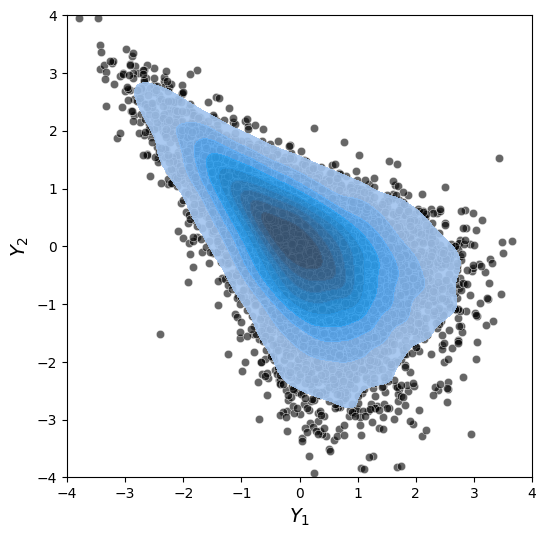

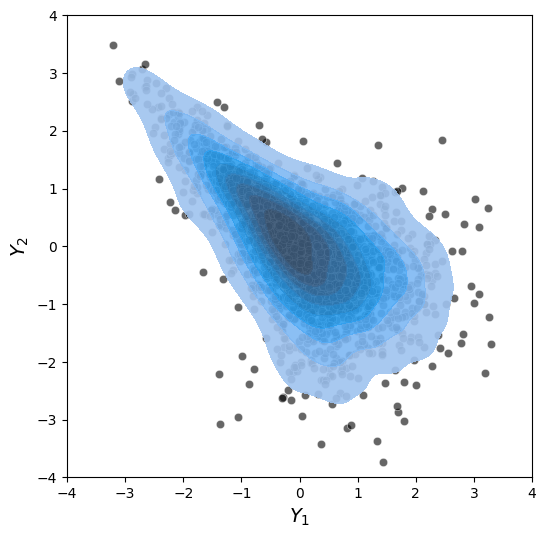

In [17]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [18]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


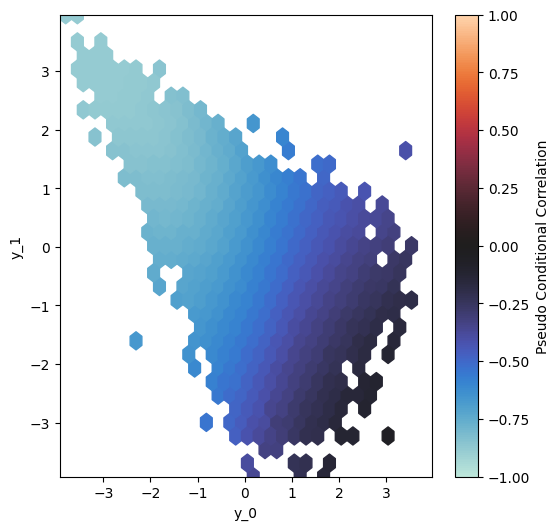

In [19]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


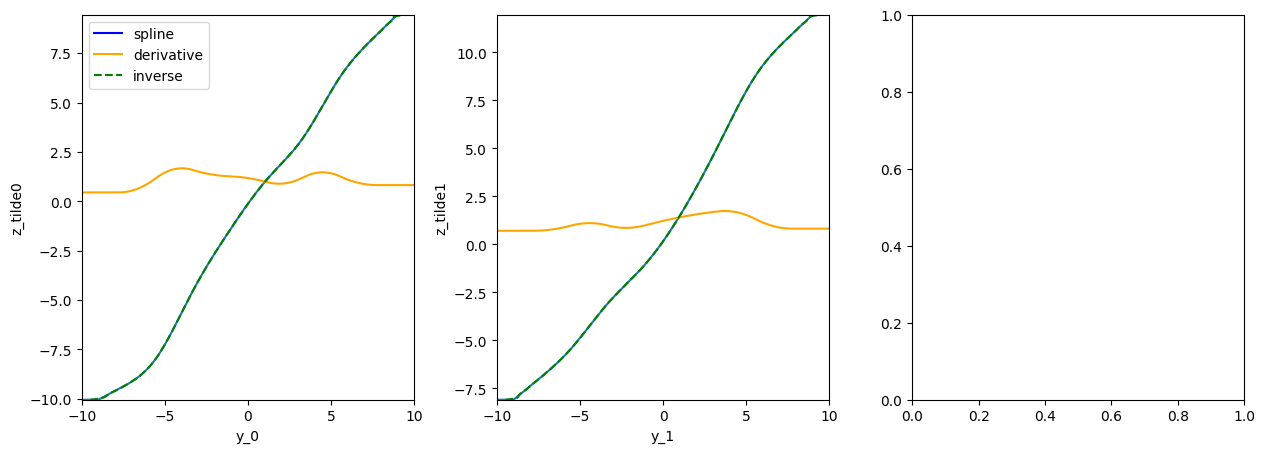

In [20]:
model.plot_splines(layer_type="transformation")

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


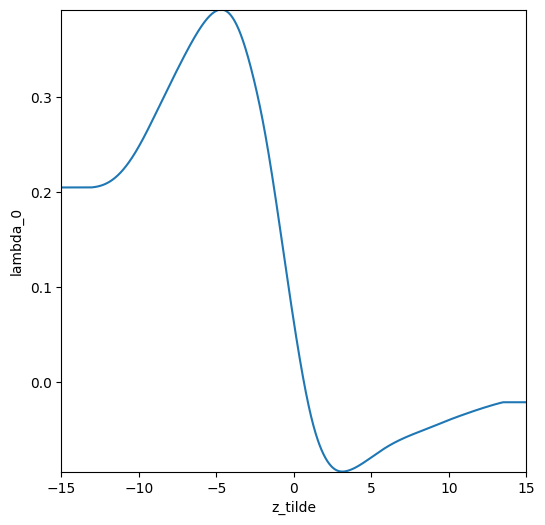

In [21]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


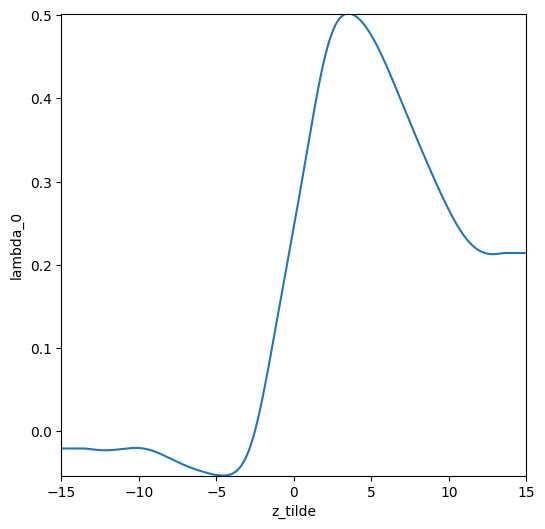

In [22]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


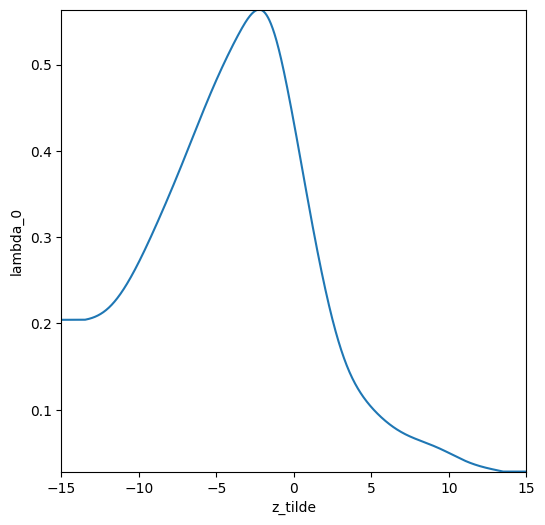

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)